<a href="https://colab.research.google.com/github/ArneRustad/course-data-science-predicting-boston-housing-prices/blob/main/DSAI_hackathon_8th_of_February_2024_Predicting_Boston_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSAI hackathon 8th of February 2024 - Predicting Boston housing prices

**Credit**: Data exploration inspired by https://www.kaggle.com/datasets/vikrishnan/boston-house-prices?resource=download

We will investigate a dataset with the following features:

1. **CRIM** - per capita crime rate by town
2. **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
3. **INDUS** - proportion of non-retail business acres per town.
4. **CHAS** - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. **NOX** - nitric oxides concentration (parts per 10 million)
6. **RM** - average number of rooms per dwelling
7. **AGE** - proportion of owner-occupied units built prior to 1940
8. **DIS** - weighted distances to five Boston employment centres
9. **RAD** - index of accessibility to radial highways
10. **TAX** - full-value property-tax rate per \$10,000
11. **PTRATIO** - pupil-teacher ratio by town
12. $B - 1000(Bk - 0.63)^2$ where $B_k$ is the proportion of blacks by town
13. **LSTAT** - % lower status of the population
14. **MEDV** - Median value of owner-occupied homes in \$1000's

## Update scikit-learn package

In [ ]:
!pip install -qU scikit-learn==1.4.0

## Fetch dataset

We have uploaded the CSV to a public Github repository where it can be directly downloaded into this notebook

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Lets' load the dataset and look at the first five rows
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('https://github.com/ArneRustad/course-data-science-predicting-boston-housing-prices/blob/main/housing.csv?raw=true', header=None, delimiter=r"\s+", names=column_names)

## Explore dataset

Let's take a look at the first five columns in the dataset

In [ ]:
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [ ]:
# Dimension of the dataset
print(np.shape(data))

(506, 14)


In [ ]:
# Let's summarize the data to see the distribution of data
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

From get-go, two data columns show interesting summeries. They are : ZN (proportion of residential land zoned for lots over 25,000 sq.ft.) with 0 for 25th, 50th percentiles. Second, CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise) with 0 for 25th, 50th and 75th percentiles. These summeries are understandable as both variables are conditional + categorical variables. First assumption would be that these coulms may not be useful in regression task such as predicting MEDV (Median value of owner-occupied homes).

Another interesing fact on the dataset is the max value of MEDV. From the original data description, it says: Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000). Based on that, values above 50.00 may not help to predict MEDV. Let's plot the dataset and see interesting trends/stats.

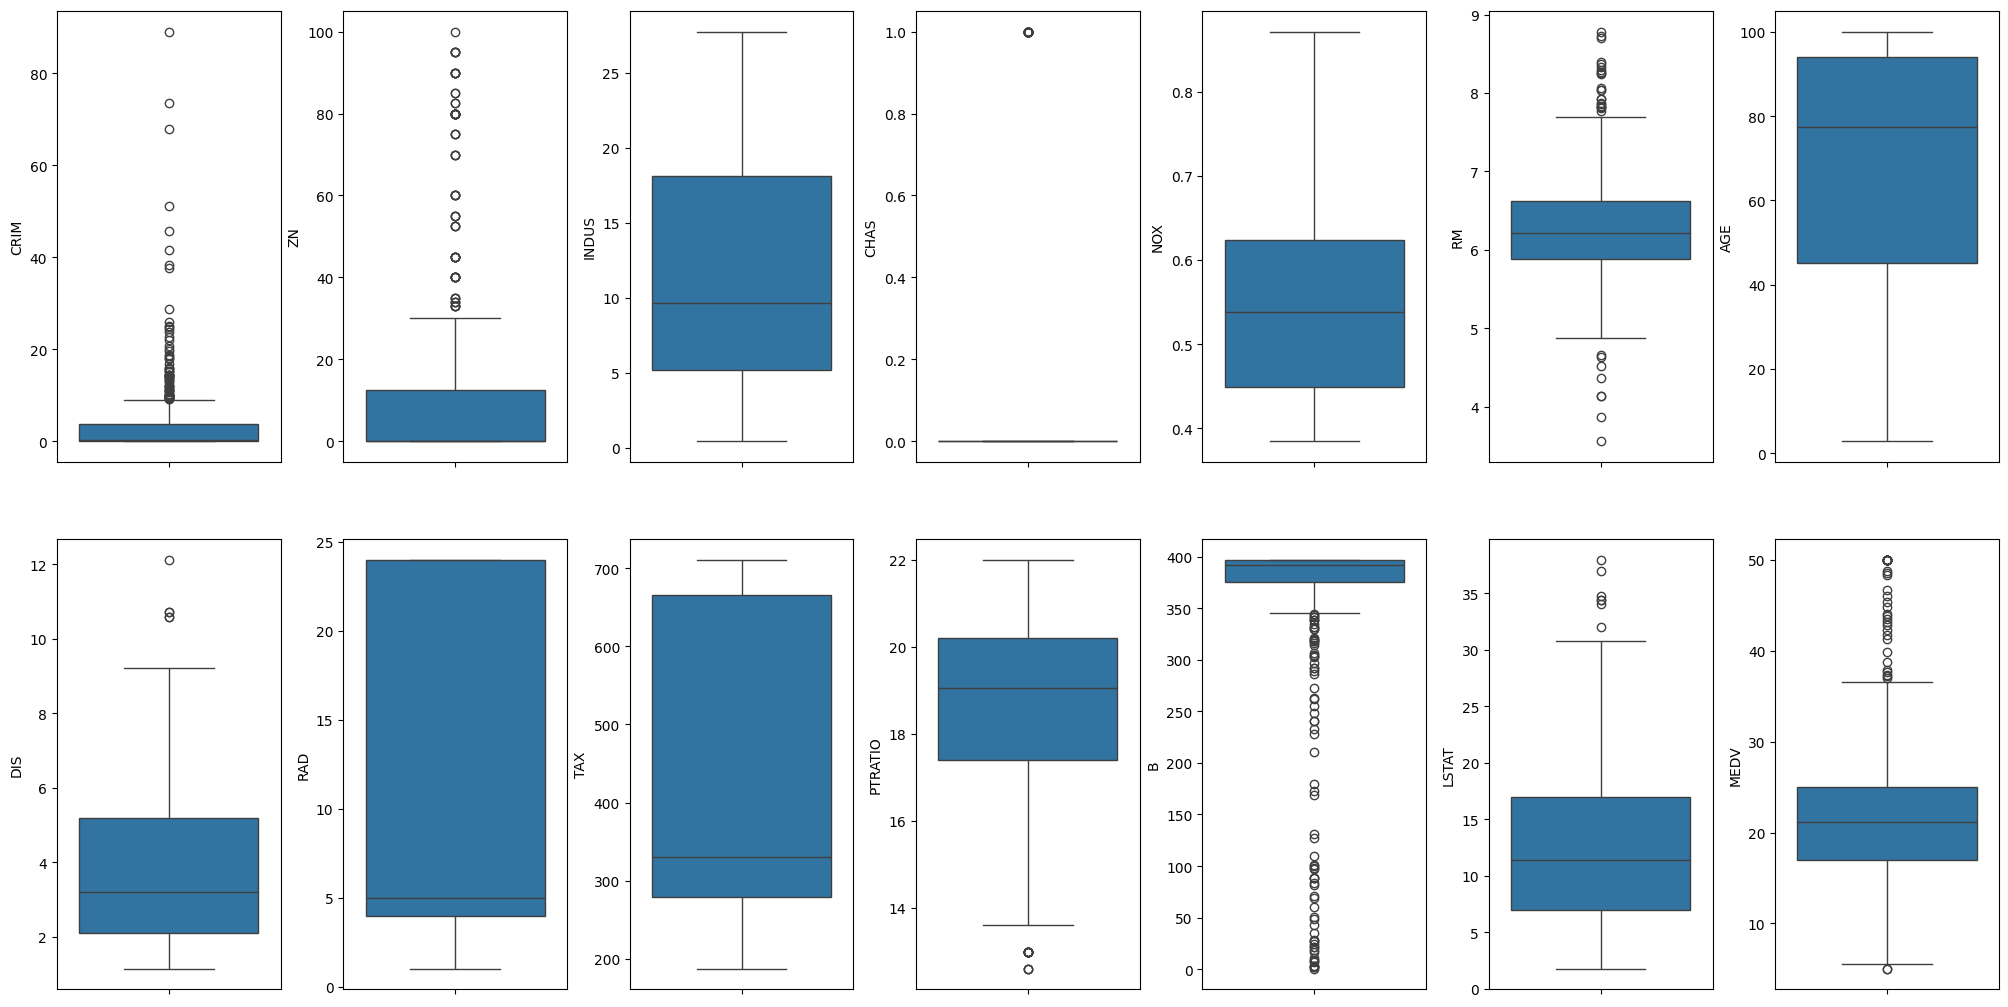

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

In [ ]:
    for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


In [ ]:
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(490, 14)


Let's see how these features plus MEDV distributions looks like

<ipython-input-42-bb467ecc5f9e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, ax=axs[index])
<ipython-input-42-bb467ecc5f9e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, ax=axs[index])
<ipython-input-42-bb467ecc5f9e>:5: UserWarning: 

`distplot` is a deprecated function and will be 

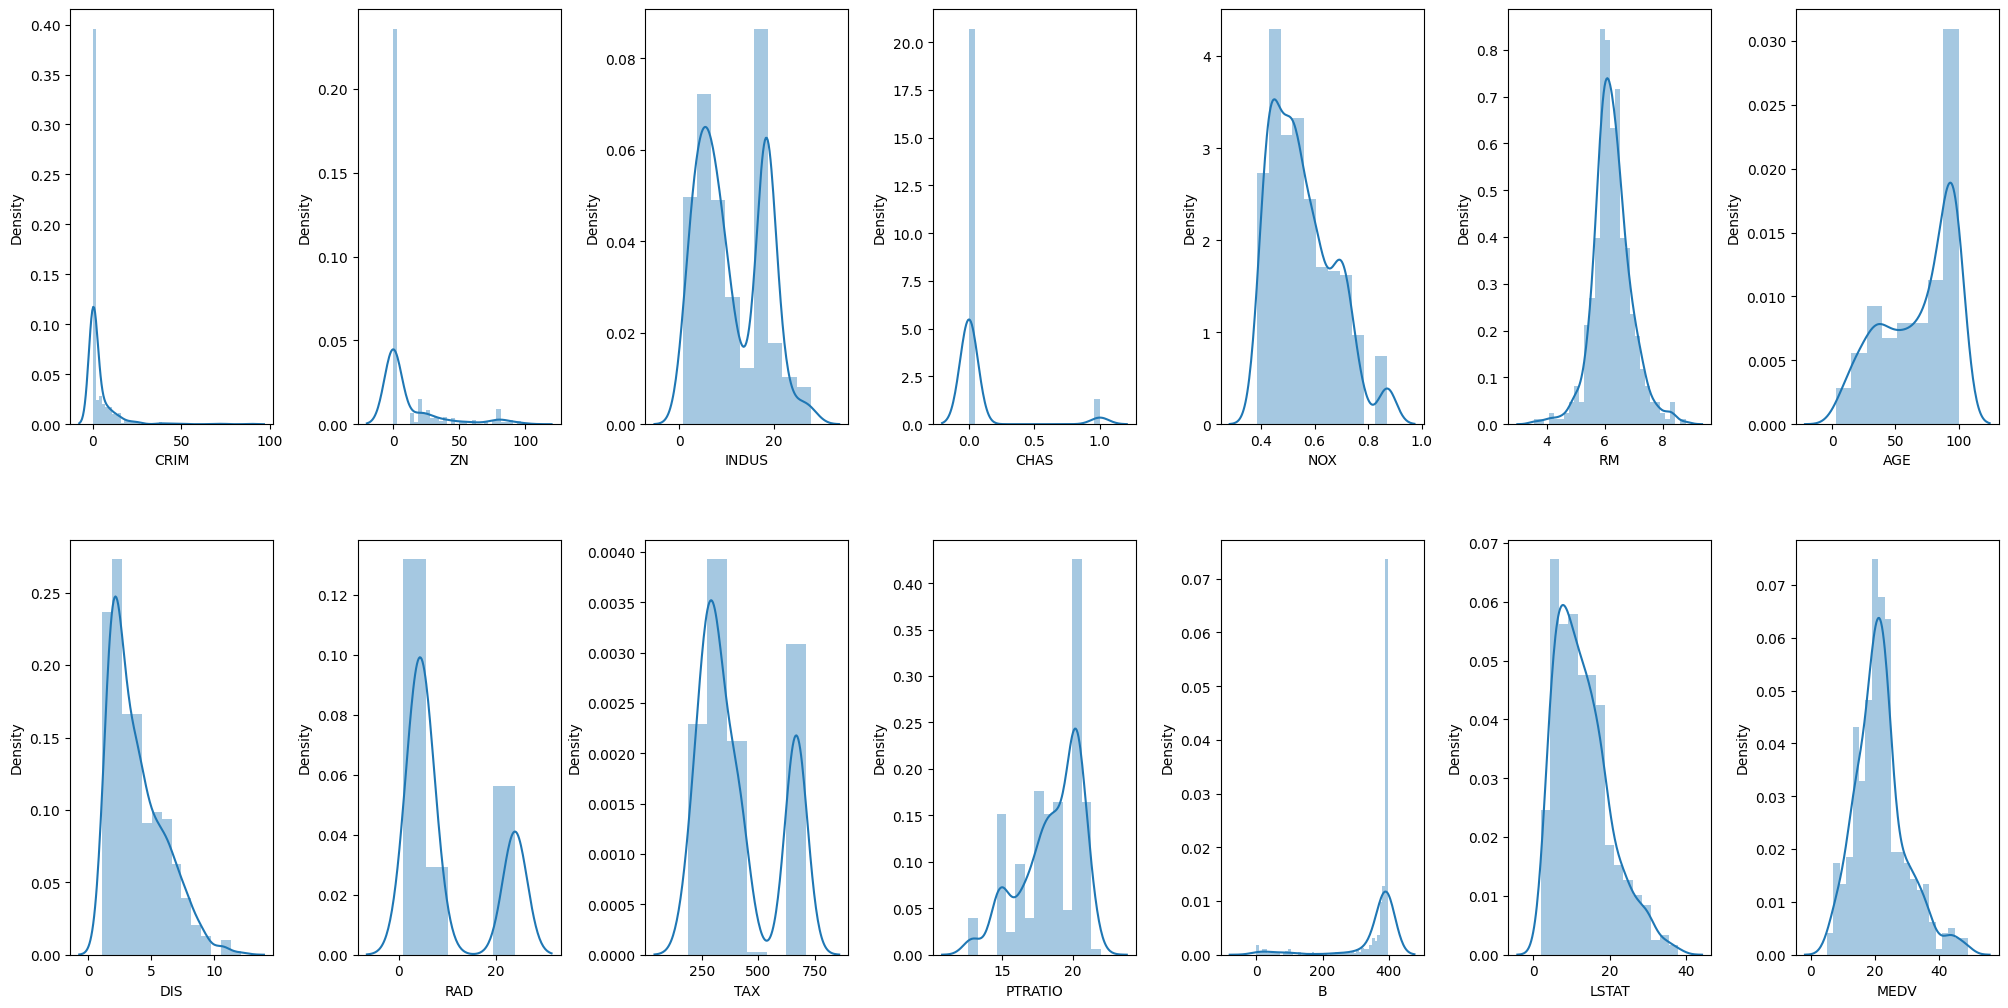

In [ ]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<Axes: >

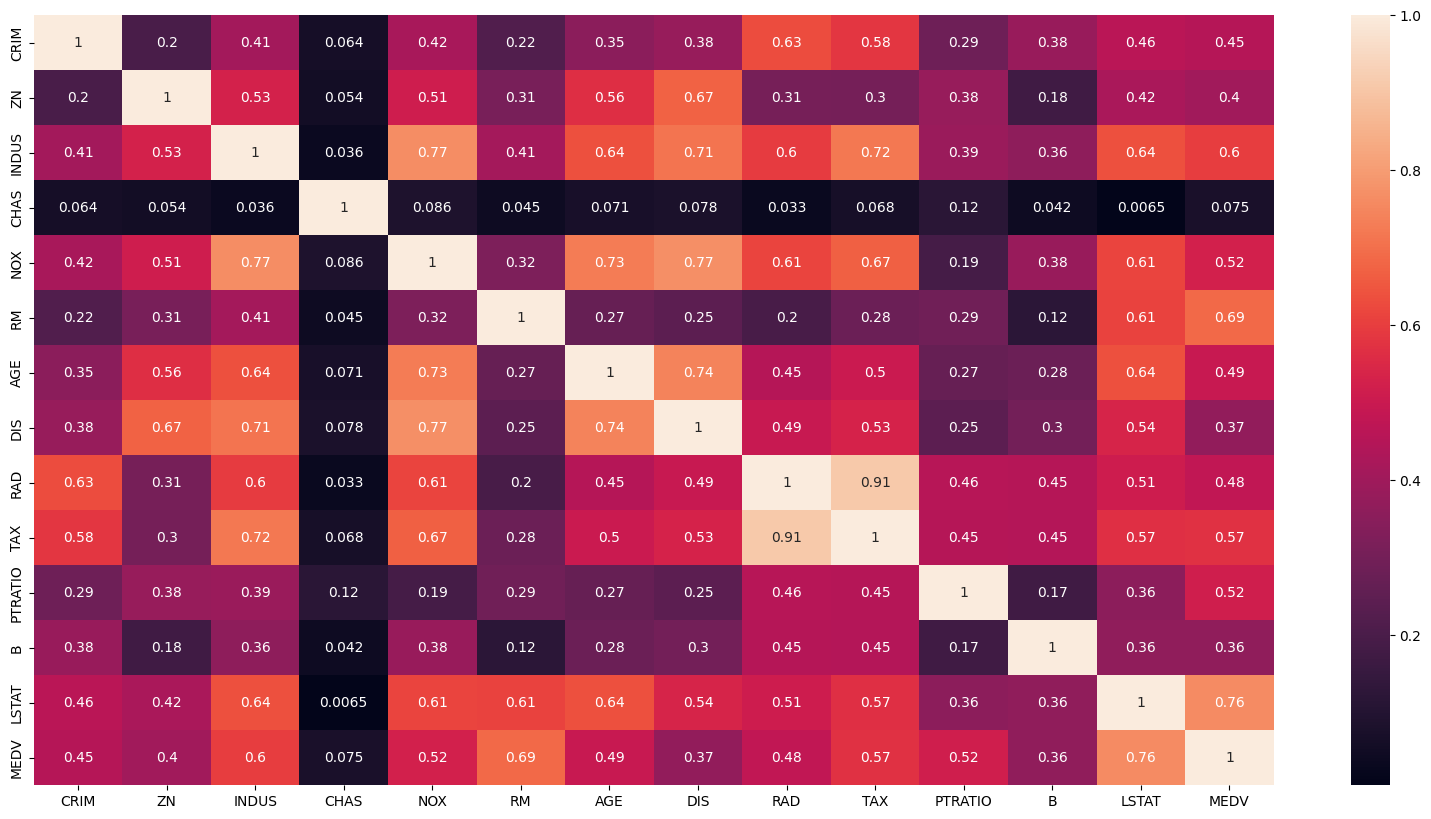

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV.

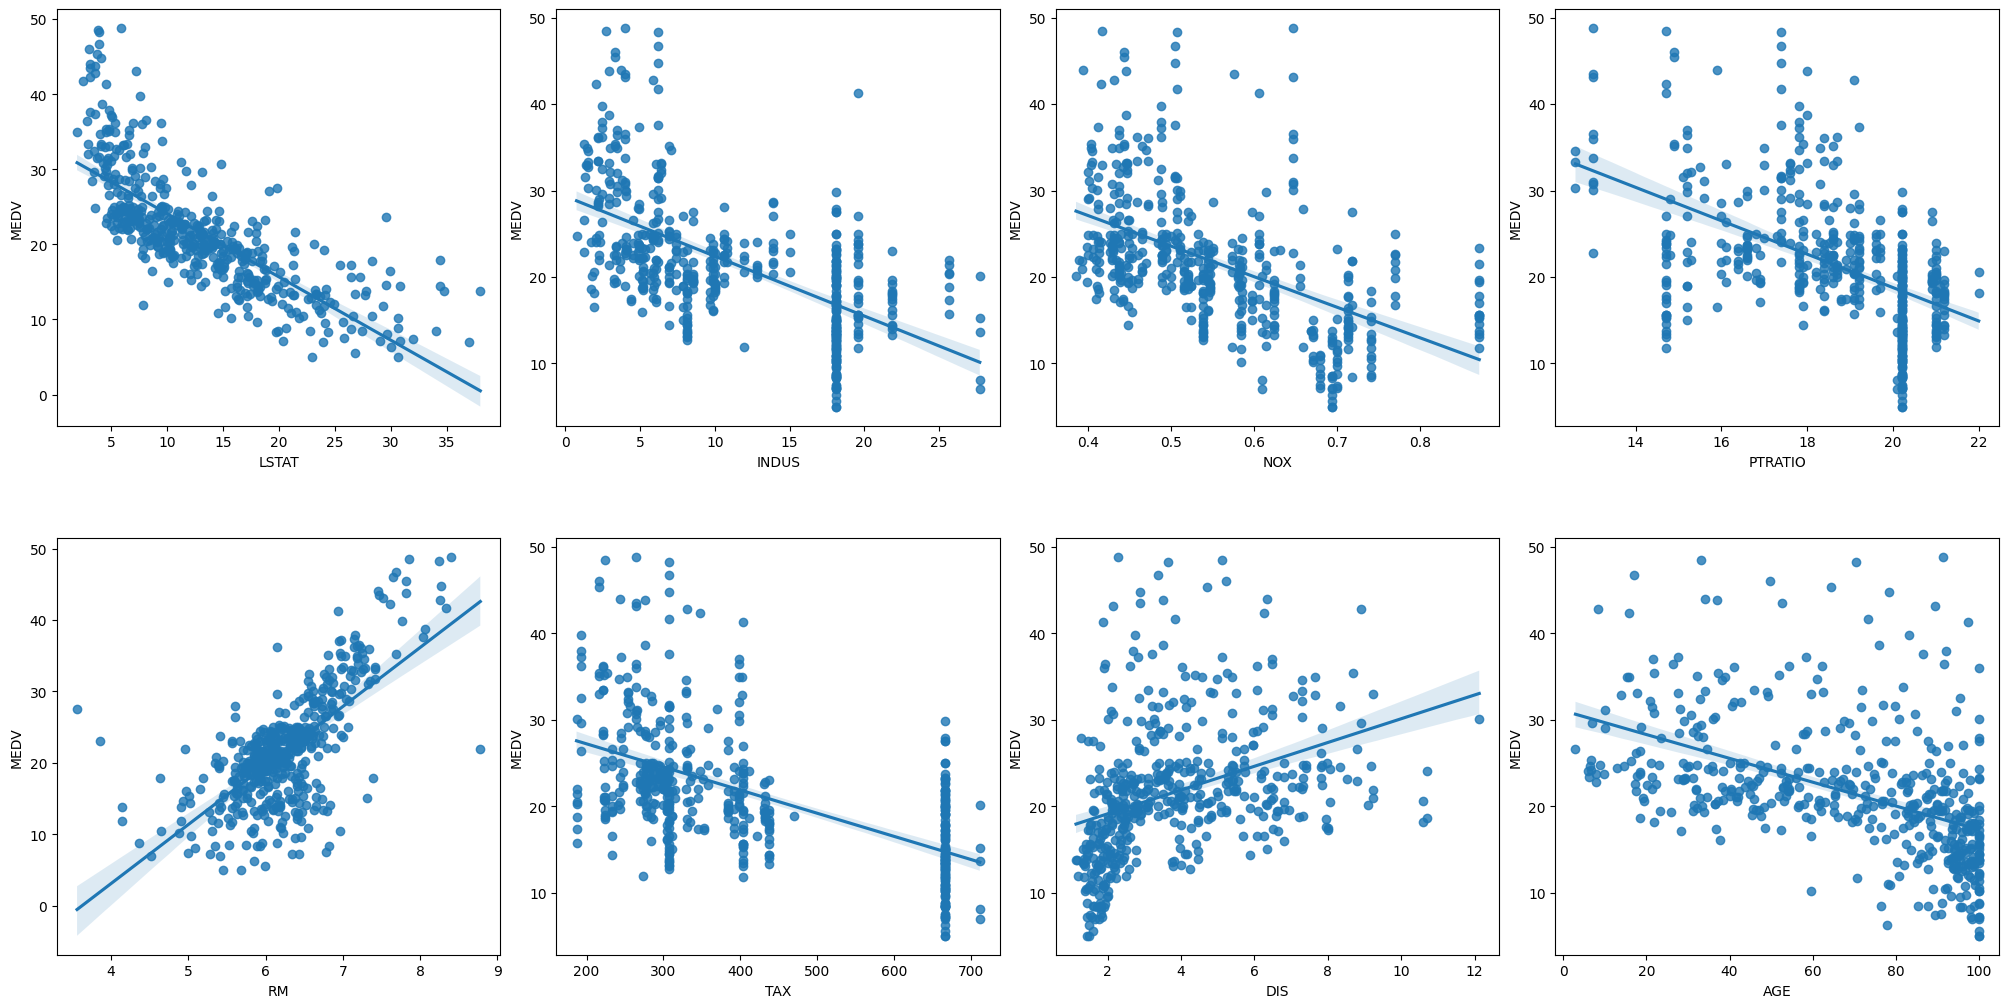

In [ ]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Divide into train, validation, and test dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

## Predict with single feature / covariate

In [ ]:
X_train_simple = X_train[["DIS"]]


<Axes: xlabel='DIS', ylabel='MEDV'>

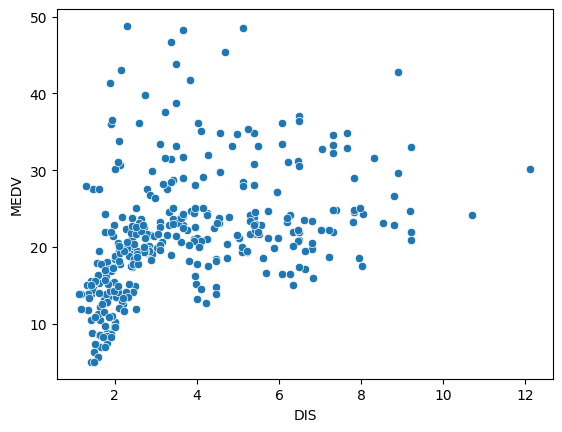

In [ ]:
sns.scatterplot(y=y_train, x=X_train_simple["DIS"])

### Predict with linear model

In [ ]:
from sklearn.linear_model import LinearRegression

model_lm_simple = LinearRegression()
model_lm_simple.fit(X_train_simple, y_train)

LinearRegression()

Let's display the predictions. To do this we will define a helper function

In [ ]:
def display_predictions2D(X, y, model, X_plot = None, x_axis_feature="DIS"):
  if X_plot is None:
    X_plot = X

  # Plot a scatterplot of the observations with DIS on the x-axis and MEDV on the y-axis
  sns.scatterplot(y=y, x=X[x_axis_feature])
  # Plot the predictions of the linear model over the range of DIS values
  sns.lineplot(y=model.predict(X_plot), x=X_plot[x_axis_feature])

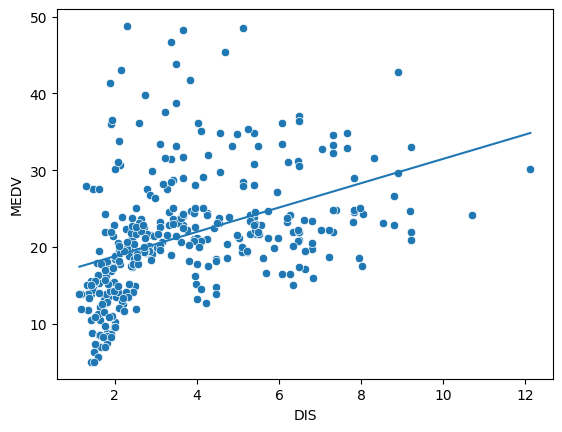

In [ ]:
# Define a dataframe with the evenly spaced values between min and max of the DIS column
X_simple_plot = pd.DataFrame.from_dict({"DIS": np.linspace(np.min(X_train_simple["DIS"]), np.max(X_train_simple["DIS"]), 1000)})

# Visualize prediction in 2D
display_predictions2D(X=X_train_simple, y=y_train, model=model_lm_simple, X_plot=X_simple_plot)

### Train polynomial linear model


In [ ]:
X_train_simple2 = X_train_simple.copy()
X_train_simple2["DIS^2"] = X_train_simple2["DIS"]**2
X_train_simple2

,DIS,DIS^2
254,9.2203,85.013932
190,6.4798,41.987808
504,2.3889,5.706843
454,2.4961,6.230515
174,2.7019,7.300264
...,...,...
98,3.4952,12.216423
492,2.1099,4.451678
333,6.4584,41.710931
398,1.4896,2.218908


In [ ]:
model_lm_simple_polynomial2 = LinearRegression()
model_lm_simple_polynomial2.fit(X_train_simple2, y_train)

LinearRegression()

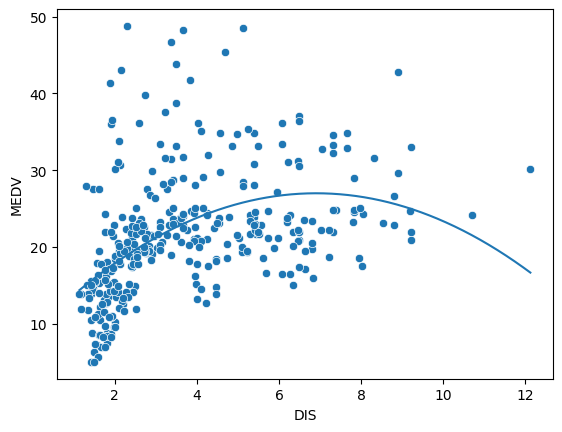

In [ ]:
# Define a dataframe with the evenly spaced values between min and max of the DIS column
X_simple_plot2 = X_simple_plot.copy()
X_simple_plot2["DIS^2"] = X_simple_plot2["DIS"]**2

# Visualize predictions in 2D
display_predictions2D(X=X_train_simple, y=y_train, model=model_lm_simple_polynomial2, X_plot=X_simple_plot2)

### Predicting with a gradient boosting tree algorithm



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model_gbt = GradientBoostingRegressor()
model_gbt.fit(X_train_simple, y_train)

GradientBoostingRegressor()

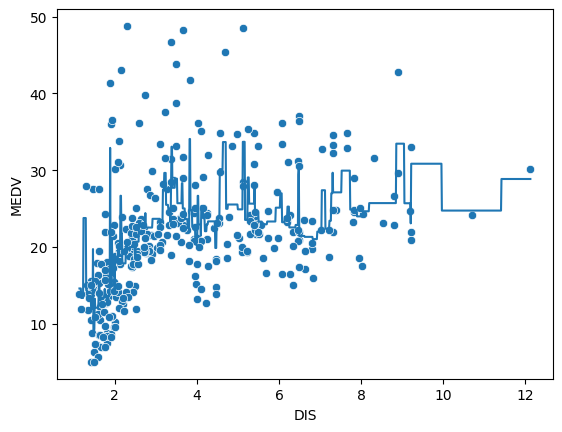

In [ ]:
# Visualize prediction in 2D
display_predictions2D(X=X_train_simple, y=y_train, model=model_gbt, X_plot=X_simple_plot)

#### Tweaking the hyperparameters of the gradient boosting tree regressor

In [ ]:
model_gbt2 = GradientBoostingRegressor(max_depth=1)
model_gbt2.fit(X_train_simple, y_train)

GradientBoostingRegressor(max_depth=1)

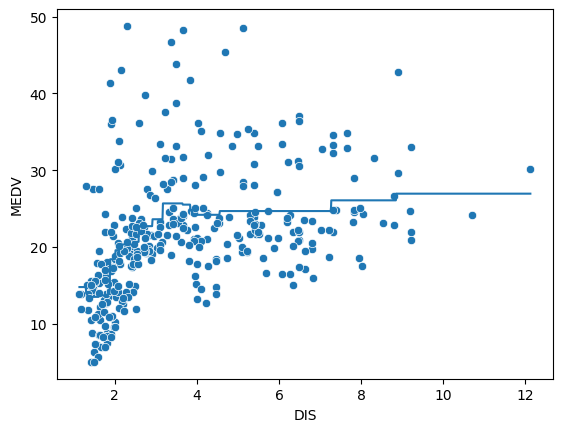

In [ ]:
# Visualize prediction in 2D
display_predictions2D(X=X_train_simple, y=y_train, model=model_gbt2, X_plot=X_simple_plot)

## Let's try training the two different types of models with full datasets and evaluate them up against the simple models

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Linear regression model
model_lm_full = LinearRegression()
model_lm_full.fit(X_train, y_train)
y_pred_lm_full = model_lm_full.predict(X_test)

# Gradient boosting model
model_gbt_full = GradientBoostingRegressor()
model_gbt_full.fit(X_train, y_train)
y_pred_gbt_full=model_gbt_full.predict(X_test)



##Evaluate the models by R2-score
R2-score is the coefficient of determination and is a common metric for showing how well a predicting model performs



In [ ]:
from sklearn.metrics import r2_score
# First create the simple predictions
y_pred_lm_simple = model_lm_simple.predict(X_test[['DIS']])
y_pred_gbt_simple=model_gbt2.predict(X_test[['DIS']])

# Calculate and print R2-scores:
R2_full_lin = r2_score(y_true = y_test, y_pred = y_pred_lm_full)
print("R2-score full dataset linear regression model R2=",R2_full_lin)

R2_simple_lin = r2_score(y_true = y_test, y_pred = y_pred_lm_simple)
print("R2-score simple dataset linear regression model R2=",R2_simple_lin)

R2_full_gbt = r2_score(y_true = y_test, y_pred = y_pred_gbt_full)
print("R2-score full dataset GBT model R2=",R2_full_gbt)

R2_simple_gbt = r2_score(y_true = y_test, y_pred = y_pred_gbt_simple)
print("R2-score simple dataset GBT model R2=",R2_simple_gbt)

R2-score full dataset linear regression model R2= 0.7534339200543962
R2-score simple dataset linear regression model R2= 0.03175278967215478
R2-score full dataset GBT model R2= 0.8523277219800699
R2-score simple dataset GBT model R2= 0.1449613931793643


## Excercise 1: Try to beat the models
Try to tweak the hyperparameters of the GBT-model yourself to beat the models we already have created.

See [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

## Exercise 2: Hyperparameter tuning
Try to use GridSearchCV to tune the hyperparameters of your model
See [documentation](https://scikit-learn.org/stable/modules/grid_search.html)


In [ ]:
from sklearn.model_selection import GridSearchCV